# Project 1
## Wolesale
### 1. load data
we load the data from a csv and then do something

In [1]:
%matplotlib inline
import numpy as np
import scipy,scipy.spatial
import torch
import torchvision,torchvision.transforms
import sqlite3
import matplotlib
from matplotlib import pyplot as plt

raw_data = np.genfromtxt("Wholesale customers data.csv", skip_header=1, delimiter=",")

In [2]:
# we are not interested in the region 
data = np.delete(raw_data, (1), axis=1) 

# seperating by channel
is_horeca = (data[:, 0]-1) == 0
data_horeca = data[is_horeca, 1:]
data_retail = data[~is_horeca, 1:]

# total spending in the catagories
totals = np.sum(data[:, 1:], axis=1)

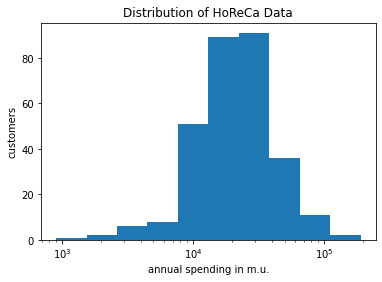

In [3]:
# we want to visualize the data to get a general overview
def graph_histogram(data, bin_count:int, name:str):

    _, ax = plt.subplots()
    _, bin_edges = np.histogram(data, bins=bin_count)
    log_bin_edges = np.logspace(np.log10(bin_edges[0]), np.log10(bin_edges[-1]), len(bin_edges))
    plt.hist(data, bins=log_bin_edges)

    plt.xscale('log')
    ax.set_title(f'Distribution of {name} Data')
    ax.set_xlabel('annual spending in m.u.')
    ax.set_ylabel('customers')

horeca_totals = np.sum(data_horeca, axis=1)
graph_histogram(horeca_totals, 10, "HoReCa")
plt.show()

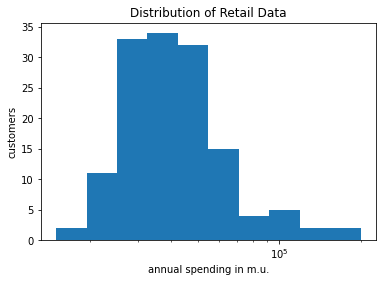

In [4]:
# we want to visualize the data to get a general overview

retail_totals = np.sum(data_retail, axis=1)
graph_histogram(retail_totals, 10, "Retail")
plt.show()